# Подготовка модели распознавания рукописных букв и цифр

Вам предстоит самостоятельно обучить модель для задачи распознавания рукописных букв и цифр с помощью датасета `emnist`. Результатом должна быть обученная модель, сохранённая в файл `model.pkl`.

Можете воспользоваться предложенным порядком действий и подсказками из этого ноутбука или подойти к решению задачи самостоятельно и написать всё с нуля. То же касается и процесса упаковки модели в сервис для распознавания самостоятельно написанных символов.

В этом ноутбуке комментариями и символами `...` отмечены места для вашего кода.

Перед отправкой решения убедитесь, что все ячейки ноутбука выполняются последовательно без ошибок, если запустить `Kernel -> Restart & Run All`.

Успехов!

### 1. Установите и импортируйте необходимые библиотеки

In [35]:
# !pip install emnist
# your pip installs here

### 2. Загрузите датасет и проанализируйте его

Датасет в качестве лейблов (или таргетов) содержит числа от 0 до 46. Каждому числу соответствует ASCII-код некоторого символа. Пары «лейбл — код» хранятся в файле `emnist-balanced-mapping.txt`.
Выведите на экран количество семплов в каждом сплите датасета и размер изображений. Также для каждого лейбла выведите соответствующий ему символ и количество тренировочных семплов, приходящееся на него.
Посмотрите на несколько примеров изображений.

_Подсказка: чтобы получить символ из ASCII-кода, нужно воспользоваться функцией_ `chr()`. _Для вашего удобства можно построить словарь_ (`dict`) _соответствий._

In [67]:
import torch
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader

# Преобразования для тренировочных данных

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(15),
        # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Lambda(lambda x: 1 - x),  # Инверсия цветов (если требуется)
        transforms.Lambda(lambda x: torch.rot90(x, 1, [1, 2])),
        # transforms.ElasticTransform(alpha=50.0, sigma=8.0),
        transforms.Normalize((0.1307,), (0.3081,)),  # Нормализация
    ]
)


# Преобразования для тестовых данных
test_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),  # Преобразование в тензор
        transforms.Lambda(lambda x: 1 - x),
        transforms.Lambda(lambda x: torch.rot90(x, 1, [1, 2])),
        transforms.Normalize((0.1307,), (0.3081,)),  # Нормализация
    ]
)

# Загрузка набора EMNIST Balanced
train_dataset = datasets.EMNIST(
    root="./data",
    split="balanced",
    train=True,
    download=False,
    transform=train_transform,
)
test_dataset = datasets.EMNIST(
    root="./data",
    split="balanced",
    train=False,
    download=False,
    transform=test_transform,
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

In [68]:
# Доступ к изображениям и меткам
images_train, labels_train = train_dataset.data, train_dataset.targets
images_test, labels_test = test_dataset.data, test_dataset.targets

# Вывод информации о данных
print(f"Train: {images_train.shape[0]} images with size: {images_train.shape[1:]}")
print(f"Test: {images_test.shape[0]} images with size: {images_test.shape[1:]}")

Train: 112800 images with size: torch.Size([28, 28])
Test: 18800 images with size: torch.Size([28, 28])


Label  |  Symbol  |  Train samples qty
--------------------------------------------------
   10  |    A     |   2400
   11  |    B     |   2400
   12  |    C     |   2400
   13  |    D     |   2400
   14  |    E     |   2400
   15  |    F     |   2400
   16  |    G     |   2400
   17  |    H     |   2400
   18  |    I     |   2400
   19  |    J     |   2400


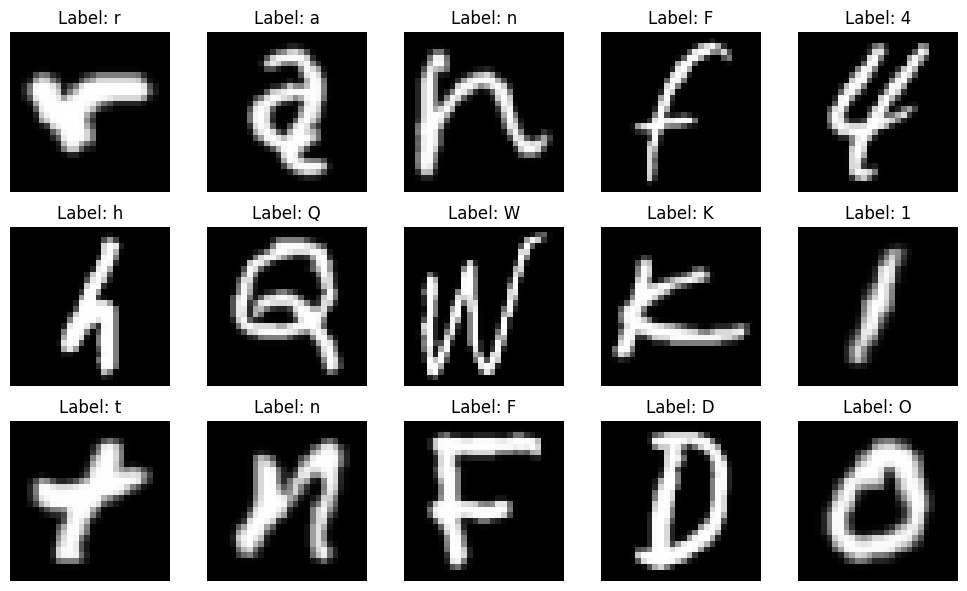

In [69]:
import matplotlib.pyplot as plt
import numpy as np


# Читаем файл с соответствием лейблов ASCII-кодам
mapping_path = "data/emnist-balanced-mapping.txt"
label_to_char = {}

with open(mapping_path, "r") as f:
    for line in f:
        label, ascii_code = map(int, line.split())
        label_to_char[label] = chr(ascii_code)

# Подсчитываем количество примеров для каждого лейбла
unique_labels, counts = np.unique(labels_train.numpy(), return_counts=True)

# Выводим соответствие лейблов символам и количество тренировочных примеров
print("Label  |  Symbol  |  Train samples qty")
print("-" * 50)
for label, count in zip(unique_labels[10:20], counts[10:20]):
    print(f"{label:5}  |    {label_to_char[label]}     |   {count}")


# Функция для корректного отображения изображений EMNIST
def emnist_visualize(image):
    image = np.transpose(image, (1, 0))  # Транспонирование (поворот на 90 градусов)
    # image = np.fliplr(image)  # Отражение по горизонтали
    return image


# Визуализация нескольких примеров изображений
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()

for i in range(15):
    corrected_image = emnist_visualize(images_train[i].numpy().squeeze())
    axes[i].imshow(corrected_image, cmap="gray")
    axes[i].set_title(f"Label: {label_to_char[labels_train[i].item()]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### 3. Подготовьте датасет для обучения и валидации

_Подсказка: чтобы вытянуть изображения в вектор, понадобится метод_ `reshape` _из библиотеки_ `numpy`.

### 4. Выберите модель, обучите её, протестируйте и сохраните

Выведите на экран точность вашей модели. Выведите и проанализируйте матрицу ошибок. Какие два символа она чаще всего путает? На каком символе модель чаще всего ошибается?

In [70]:
# Проверка доступности CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [71]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Свёрточные слои + BatchNorm
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Полносвязные слои + BatchNorm + Dropout
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, num_classes)

        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Убедимся, что входные данные имеют нужную размерность

        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # Разворачивание перед FC-слоями

        # x = self.dropout(F.relu(self.bn_fc1(self.fc1(x))))
        # x = self.dropout(F.relu(self.bn_fc2(self.fc2(x))))
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = F.leaky_relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)

        return x



# Количество классов в EMNIST Balanced
num_classes = 47  # EMNIST Balanced содержит 47 классов

# Инициализация модели
model = SimpleCNN(num_classes).to(device)

In [76]:
from torch import optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)



In [77]:
from tqdm import tqdm


def train(model, train_loader, criterion, optimizer, num_epochs):
    # running_losses = []
    model.train()
    for epoch in range(num_epochs):
        # running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            # Перенос данных на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # if epoch % 2 == 0:
        val_loss = []  # сюда будем складывать **средний по бачу** лосс
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in test_loader:
                y_pred = model(x_val.to(device))  # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val.to(device))  # считаем лосс
                val_loss.append(loss.cpu().numpy())  # добавляем в массив
                val_accuracy.extend(
                    (torch.argmax(y_pred, dim=-1) == y_val.to(device))
                    .cpu()
                    .numpy()
                    .tolist()
                )

        # скидываем метрики на wandb и автоматом смотрим на графики
        # wandb.log(
        #     {
        #         "mean val loss": np.mean(val_loss),
        #         "mean val accuracy": np.mean(val_accuracy),
        #     }
        # )

        # печатаем метрики
        print(
            f"Epoch: {epoch + 1}, loss: {np.mean(val_loss):.4f}, accuracy: {np.mean(val_accuracy):.4f}"
        )

        # running_loss += loss.item()
    #     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / 100:.4f}")
    #     running_loss /= len(train_loader)
    #     running_losses.append(running_loss)
    # return running_losses

In [78]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Перенос данных на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    delim = '=' * 50
    print(f'\n{delim}\nAccuracy of the model on the test images: {acc:.2f}%\n{delim}')
    return acc

In [79]:
# Запуск обучения
# train_losses = train(model, train_loader, criterion, optimizer, num_epochs=10)
train(model, train_loader, criterion, optimizer, num_epochs=10)

# Проверка точности модели
accuracy = test(model, test_loader)

100%|██████████| 1763/1763 [00:16<00:00, 104.66it/s]


Epoch: 1, loss: 0.3671, accuracy: 0.8981


100%|██████████| 1763/1763 [00:15<00:00, 115.37it/s]


Epoch: 2, loss: 0.3652, accuracy: 0.8988


100%|██████████| 1763/1763 [00:15<00:00, 111.52it/s]


Epoch: 3, loss: 0.3653, accuracy: 0.8995


100%|██████████| 1763/1763 [00:16<00:00, 105.21it/s]


Epoch: 4, loss: 0.3636, accuracy: 0.9011


100%|██████████| 1763/1763 [00:17<00:00, 102.93it/s]


Epoch: 5, loss: 0.3637, accuracy: 0.9006


100%|██████████| 1763/1763 [00:21<00:00, 81.72it/s] 


Epoch: 6, loss: 0.3631, accuracy: 0.9009


100%|██████████| 1763/1763 [00:17<00:00, 101.07it/s]


Epoch: 7, loss: 0.3636, accuracy: 0.9006


100%|██████████| 1763/1763 [00:16<00:00, 104.47it/s]


Epoch: 8, loss: 0.3629, accuracy: 0.9013


100%|██████████| 1763/1763 [00:16<00:00, 107.43it/s]


Epoch: 9, loss: 0.3622, accuracy: 0.9015


100%|██████████| 1763/1763 [00:18<00:00, 93.76it/s] 


Epoch: 10, loss: 0.3627, accuracy: 0.9019

Accuracy of the model on the test images: 90.27%


In [80]:
from sklearn.metrics import confusion_matrix
import numpy as np

def get_confusion_matrix(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Создание матрицы ошибок
    cm = confusion_matrix(all_labels, all_predictions)
    return cm

# Получение матрицы ошибок
cm = get_confusion_matrix(model, test_loader, device)

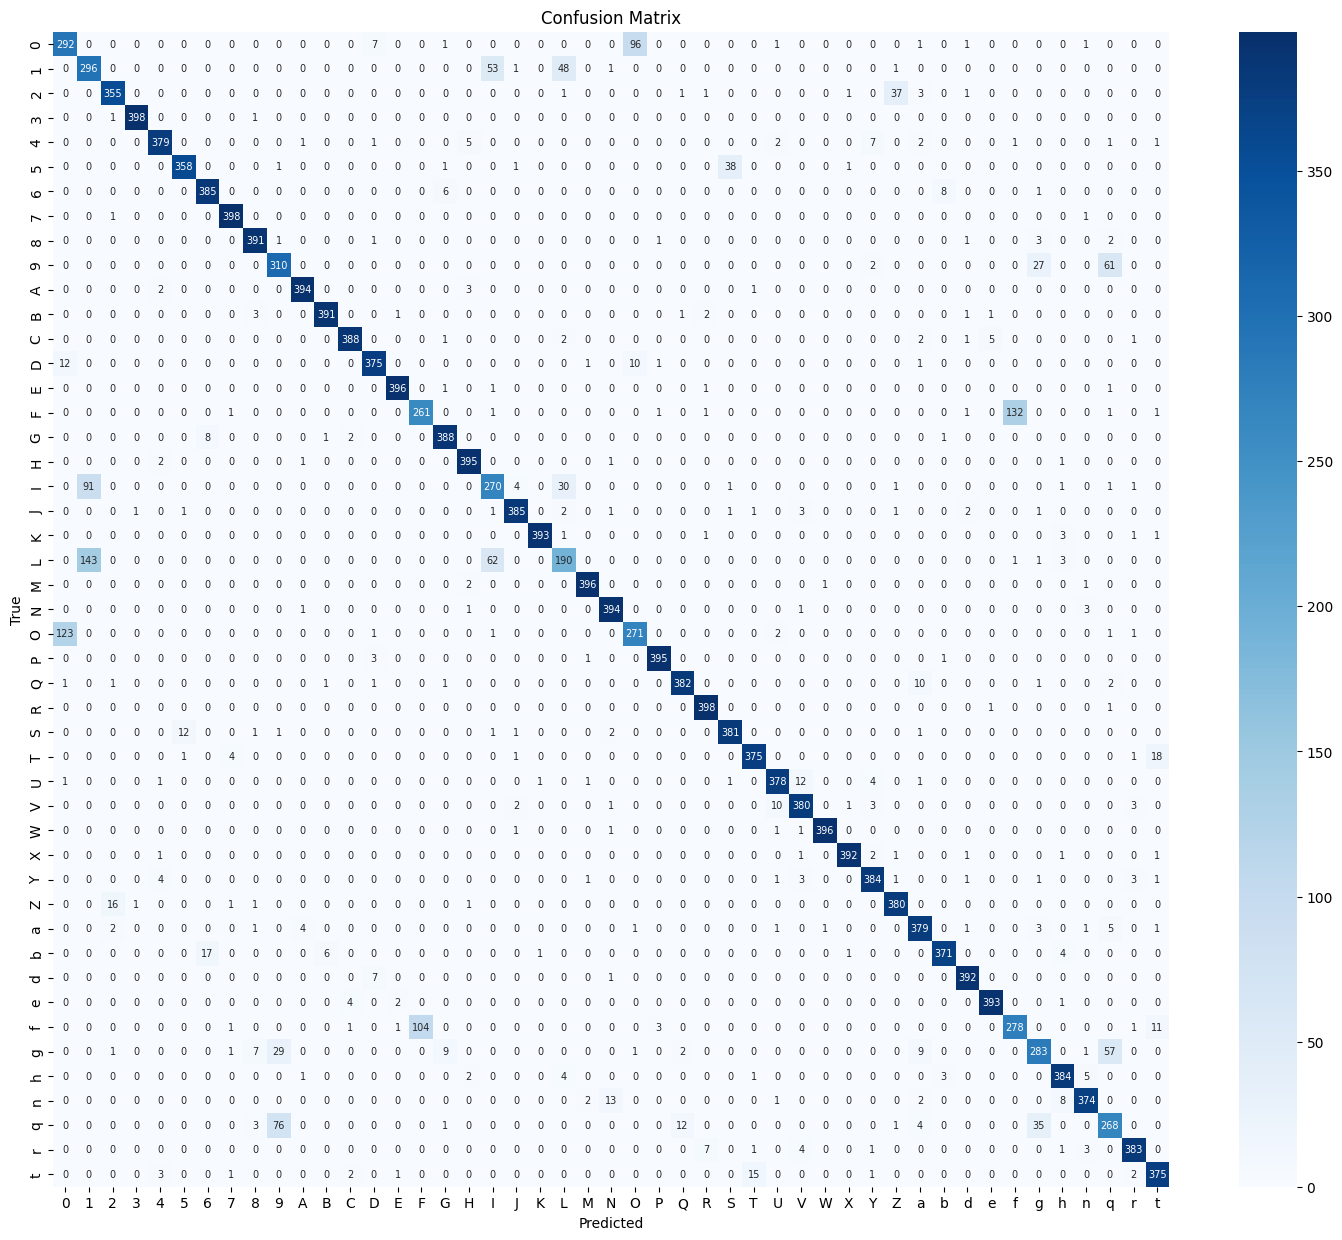

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(18, 15))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size": 7},
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# Пример названий классов для EMNIST Balanced
# class_names = [str(i) for i in range(num_classes)]  # Замените на реальные названия классов, если они известны
class_names = label_to_char.values()

# Визуализация матрицы ошибок
plot_confusion_matrix(cm, class_names)

In [82]:
symbols = "".join(class_names)
symbols

'0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [83]:
def find_most_common_errors(cm, symbols):
    # class_names = list(class_names)
    errors = []
    for i in range(len(symbols)):
        for j in range(len(symbols)):
            if i != j and cm[i, j] > 0:  # Игнорируем диагональ и нулевые значения
                errors.append((symbols[i], symbols[j], cm[i, j]))
    
    # Сортировка по количеству ошибок
    errors.sort(key=lambda x: x[2], reverse=True)
    return errors

# Получение списка наиболее частых ошибок
common_errors = find_most_common_errors(cm, symbols)

# Вывод топ-10 ошибок
for true_label, predicted_label, count in common_errors[:20]:
    print(f'True: {true_label:<2} -  Predicted: {predicted_label:<2} -  Count: {count}')

True: L  -  Predicted: 1  -  Count: 143
True: F  -  Predicted: f  -  Count: 132
True: O  -  Predicted: 0  -  Count: 123
True: f  -  Predicted: F  -  Count: 104
True: 0  -  Predicted: O  -  Count: 96
True: I  -  Predicted: 1  -  Count: 91
True: q  -  Predicted: 9  -  Count: 76
True: L  -  Predicted: I  -  Count: 62
True: 9  -  Predicted: q  -  Count: 61
True: g  -  Predicted: q  -  Count: 57
True: 1  -  Predicted: I  -  Count: 53
True: 1  -  Predicted: L  -  Count: 48
True: 5  -  Predicted: S  -  Count: 38
True: 2  -  Predicted: Z  -  Count: 37
True: q  -  Predicted: g  -  Count: 35
True: I  -  Predicted: L  -  Count: 30
True: g  -  Predicted: 9  -  Count: 29
True: 9  -  Predicted: g  -  Count: 27
True: T  -  Predicted: t  -  Count: 18
True: b  -  Predicted: 6  -  Count: 17


In [58]:
metadata = {
    'model_name': type(model).__name__,
    'num_classes': num_classes,
    'epochs_trained': 5,
    'optimizer_state': optimizer.state_dict(),
    'loss': 'CrossEntropyLoss',
    'dataset': 'EMNIST Balanced',
    'description': 'EMNIST symbol classification model',
    'version': '1.0',
    'accuracy': accuracy,
}

# Сохраняем модель и метаданные в один файл
torch.save({
    'model_state_dict': model.state_dict(),  # Сохраняем параметры модели
    'metadata': metadata                    # Сохраняем метаданные
}, 'model/EMNIST_CNN.pth')